# Main file
This file will apply the portrait tool on different pictures and show them for comparison.

In [1]:
# Imports
import cv2
import numpy as np

from utils import load_image, show_image
from sobel import sobel_edge_detection, edge_enhancer
from wavelets import dwt2_edge_detection


In [2]:
# We treat edges and make *sure* that the contour is closed
def close_contour(edges, kernel, lower_threshold, upper_threshold):
    binary_mask = cv2.inRange(edges, lower_threshold, upper_threshold)

    dilated = cv2.dilate(binary_mask, kernel, iterations=3)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    cleaned = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, kernel)

    return cleaned

def fill_contour(contour):
    # Here we assume that the contur is connected. And we do flood fill from each corner
    # This will give us where "holes" inside the contour are. We use this to fill the mask

    inverted_mask = cv2.bitwise_not(contour)

    flood_filled = inverted_mask.copy()
    h, w = inverted_mask.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)  # Padding

    # flood fill from each of the corners
    corners = [(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)]
    for corner in corners:
        cv2.floodFill(flood_filled, mask, corner, 0)

    flood_filled_inv = cv2.bitwise_not(flood_filled)

    return np.where(flood_filled_inv == 0, 255, contour)

def get_largest_contour(original_image, filled_image, kernel, convex=False):
    # For our convex hull solution we find the biggest contour.
    # This filled contour is also used for just mask solution.

    contours, _ = cv2.findContours(filled_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found")
        return

    mask = np.zeros_like(original_image)
    largest_contour = max(contours, key=cv2.contourArea)
    image_with_contour = original_image.copy()
    cv2.drawContours(image_with_contour, [largest_contour], -1, (0, 255, 0), thickness=3)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    cv2.imwrite('output/after_dilated_mask.png', mask)

    if convex:
        convex = cv2.convexHull(largest_contour)
        cv2.drawContours(mask, [convex], -1, (255), thickness=cv2.FILLED)

        # Refine mask using morphological operations (optional, for smoothing)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
    else:
        # Make mask smoother
        smooth_kernel = np.ones((50, 50), np.uint8)
        cleaned_smooth = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, smooth_kernel)

        # Gaussian Blur for softer edges
        smoothed_mask = cv2.GaussianBlur(cleaned_smooth, (15, 15), 0)

        # Convert back to a binary mask using thresholdingx
        _, mask = cv2.threshold(smoothed_mask, 127, 255, cv2.THRESH_BINARY)


    # result = cv2.bitwise_and(original_image, original_image, mask=mask)
    return mask

In [3]:
def extract_object(
    img,
    s_gaussian = 3,          # Gaussian smooth sigma value
    m_low_threshold = 20,    # Lower threshold for mask (mostly for Sobel)
    m_high_threshold = 255,  # Upper threshold for mask (mostly for Sobel)
    kernel = np.ones((8, 8), np.uint8)    # Kernel to close gaps
):
    # Get image and convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Smooth to remove small edges
    # img_gray_smooth = gaussian_smooth(img_gray, s_gaussian)
    img_gray_smooth = cv2.GaussianBlur(img_gray, (5, 5), s_gaussian)

    # Perform Sobel edge detection and Wavelet edge detection
    edges_sobel = sobel_edge_detection(img_gray_smooth)

    # Perform edge enhancing
    # TODO Check the result with/without enhancing
    # edges_sobel_enhanced = edge_enhancer(edges_sobel)

    # Close contours
    edges_sobel_closed = close_contour(edges_sobel, kernel, m_low_threshold, m_high_threshold)

    # Fill contour
    edges_sobel_filled = fill_contour(edges_sobel_closed)

    # Get largest contour as a mask
    mask_sobel = get_largest_contour(edges_sobel_filled, edges_sobel_filled, kernel)

    # Convert mask to 0 and 1
    mask_sobel = (mask_sobel /255).astype(int)

    # Extract object using both masks
    obj_sobel = np.expand_dims(mask_sobel, axis=-1) * img

    # Smooth background
    background = cv2.GaussianBlur(img, (11, 11), 5)

    # Get mask for background
    mask_sobel_inv = 1 - mask_sobel

    # Extract background without obj from image
    bg_sobel = background * np.expand_dims(mask_sobel_inv, axis=-1)

    return (obj_sobel, bg_sobel)



In [4]:
def extract_object_sobel(
    img,
    s_gaussian = 3,          # Gaussian smooth sigma value
    w_type = 'haar',         # Type of wavelet
    w_depth = 2,             # Depth of wavelet transform
    w_high = 230,            # Upper threshold for wavelet
    w_low = 17,              # Lower threshold for wavelet
    m_low_threshold = 20,    # Lower threshold for mask (mostly for Sobel)
    m_high_threshold = 255,  # Upper threshold for mask (mostly for Sobel)
    kernel = np.ones((8, 8), np.uint8)    # Kernel to close gaps
):
    # Get image and convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Smooth to remove small edges
    # img_gray_smooth = gaussian_smooth(img_gray, s_gaussian)
    img_gray_smooth = cv2.GaussianBlur(img_gray, (5, 5), s_gaussian)

    # Perform Sobel edge detection and Wavelet edge detection
    edges_sobel = sobel_edge_detection(img_gray_smooth)
    edges_wavelet = dwt2_edge_detection(img_gray_smooth, w_type, w_depth, w_high, w_low)

    # Perform edge enhancing
    # TODO Check the result with/without enhancing
    # edges_sobel_enhanced = edge_enhancer(edges_sobel)
    # edges_wavelet_enhanced = edge_enhancer(edges_wavelet)

    # Close contours
    edges_sobel_closed = close_contour(edges_sobel, kernel, m_low_threshold, m_high_threshold)
    edges_wavelet_closed = close_contour(edges_wavelet, kernel, m_low_threshold, m_high_threshold)

    # Fill contour
    edges_sobel_filled = fill_contour(edges_sobel_closed)
    edges_wavelet_filled = fill_contour(edges_wavelet_closed)

    # Get largest contour as a mask
    mask_sobel = get_largest_contour(edges_sobel_filled, edges_sobel_filled, kernel)
    mask_wavelet = get_largest_contour(edges_wavelet_filled, edges_wavelet_filled, kernel)

    # Convert mask to 0 and 1
    mask_sobel = (mask_sobel /255).astype(int)
    mask_wavelet = (mask_wavelet /255).astype(int)

    # Extract object using both masks
    obj_sobel = np.expand_dims(mask_sobel, axis=-1) * img
    obj_wavelet = np.expand_dims(mask_wavelet, axis=-1) * img

    # Smooth background
    background = cv2.GaussianBlur(img, (11, 11), 5)

    # Get mask for background
    mask_sobel_inv = 1 - mask_sobel
    mask_wavelet_inv = 1 - mask_wavelet

    # Extract background without obj from image
    bg_sobel = background * np.expand_dims(mask_sobel_inv, axis=-1)
    bg_wavelet = background * np.expand_dims(mask_wavelet_inv, axis=-1)

    return (obj_sobel, obj_wavelet, bg_sobel, bg_wavelet)



In [51]:
def extract_object_wavelet(
    img,
    s_gaussian = 3,          # Gaussian smooth sigma value
    w_type = 'haar',         # Type of wavelet
    w_depth = 2,             # Depth of wavelet transform
    w_high = 230,            # Upper threshold for wavelet
    w_low = 17,              # Lower threshold for wavelet
    w_use_horizontal=True,   # Leave in or out horizontal details 
    m_low_threshold = 20,    # Lower threshold for mask (mostly for Sobel)
    m_high_threshold = 255,  # Upper threshold for mask (mostly for Sobel)
    kernel = np.ones((8, 8), np.uint8),    # Kernel to close gaps
    padding_size = 0         # Size of padding around the mask to help fill
):
    # Get image and convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Smooth to remove small edges
    # img_gray_smooth = gaussian_smooth(img_gray, s_gaussian)
    img_gray_smooth = cv2.GaussianBlur(img_gray, (5, 5), s_gaussian)

    # Perform Wavelet edge detection
    edges = dwt2_edge_detection(img_gray_smooth, w_type, w_depth, w_high, w_low, w_use_horizontal)

    # Perform edge enhancing
    # TODO Check the result with/without enhancing
    edges_enhanced = edge_enhancer(edges)

    # Pad edge image to help fill algorithm
    edges_pad = np.pad(edges_enhanced, (padding_size, padding_size), mode='constant', constant_values=0)

    # Close contours
    edges_closed = close_contour(edges_pad, kernel, m_low_threshold, m_high_threshold)

    # Fill contour
    edges_filled = fill_contour(edges_closed)

    # Get largest contour as a mask
    mask = get_largest_contour(edges_filled, edges_filled, kernel)

    # Convert mask to 0 and 1
    mask = (mask /255).astype(np.uint8)

    # Cut out original size
    mask = mask[padding_size: padding_size + img.shape[0], padding_size: padding_size + img.shape[1]]

    # Get mask for background
    mask_inv = 1 - mask

    return mask, mask_inv

    # Extract object and background
    obj = img * np.expand_dims(mask, axis=-1)

    # Blur image and cut out background
    img_blurred = cv2.GaussianBlur(img, (15, 15), 0)
    bg = img_blurred * np.expand_dims(mask_inv, axis=-1)

    return (obj, bg)



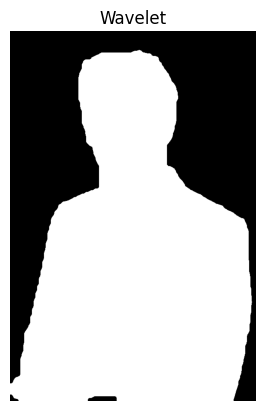

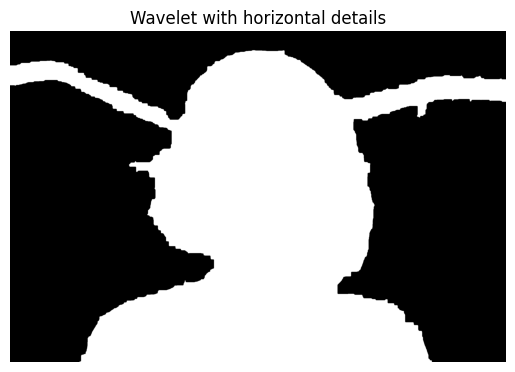

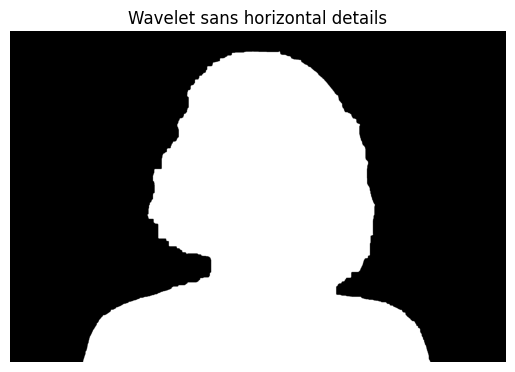

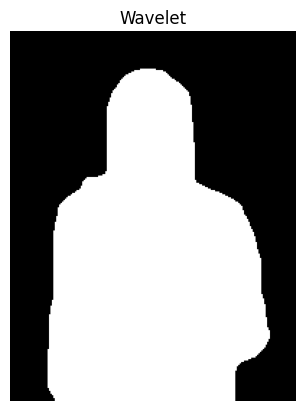

In [52]:
# Paths for all images
IMG_PATH = 'images/'
IMG_NAMES = [
    'plain_background_portrait.jpg',
    'girl.jpeg', 
    'oppenheimer_1.png', 
    # 'gandhi.jpg'
]

images = [load_image(IMG_PATH + name) for name in IMG_NAMES]

plain       = images[0]
woman       = images[1]
oppenheimer = images[2]

# plain_sobel, plain_wavelet, bg_plain_sobel, bg_plain_wavelet = extract_object(plain, s_gaussian=1.8)
# show_images([plain, plain_sobel, plain_wavelet], ["Original", "Processed Sobel", "Processed Wavelet"])

# Process plain using wavelet
plain_wavelet, bg_plain_wavelet = extract_object_wavelet(plain, s_gaussian=1, w_depth=2, w_high=254, w_low=1, kernel=(4, 4), padding_size=20)
show_image(plain_wavelet, "Wavelet")

# Process woman using wavelet
woman_wavelet_horizon, bg_woman_wavelet_horizon = extract_object_wavelet(woman, s_gaussian=1, w_depth=2, w_high=253, w_low=2, kernel=(1, 1), padding_size=0)
woman_wavelet, bg_woman_wavelet = extract_object_wavelet(woman, s_gaussian=1.5, w_depth=2, w_high=253, w_low=3, w_use_horizontal=False, kernel=(4, 4), padding_size=0)
show_image(woman_wavelet_horizon, "Wavelet with horizontal details")
show_image(woman_wavelet, "Wavelet sans horizontal details")

# Process oppenheimer using wavelet
height, width, channel = oppenheimer.shape
white_row = np.ones((1, width, channel), dtype=np.uint8) * 255
oppenheimer = np.vstack((oppenheimer, white_row))
oppenheimer_wavelet, bg_oppenheimer_wavelet = extract_object_wavelet(oppenheimer, w_type='coif1', s_gaussian=3.7, w_depth=2, w_high=220, w_low=20, kernel=(4, 4), padding_size=30)
show_image(oppenheimer_wavelet, "Wavelet")
# TODO this one shows tith other kind of wavelet. Nice to use to compare
# oppenheimer_wavelet, bg_oppenheimer_wavelet = extract_object_wavelet(oppenheimer, w_type='db2', s_gaussian=1.5, w_depth=1, w_high=193, w_low=17, kernel=(4, 4), padding_size=30)
# show_image(oppenheimer_wavelet, "Wavelet")

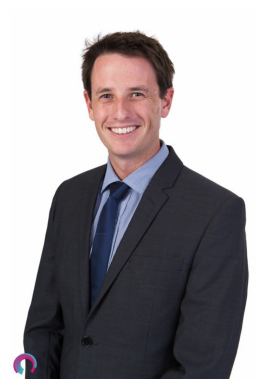

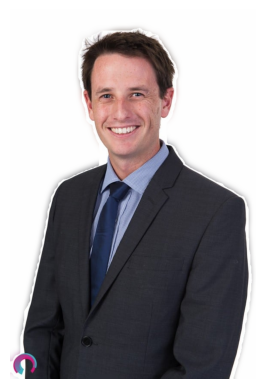

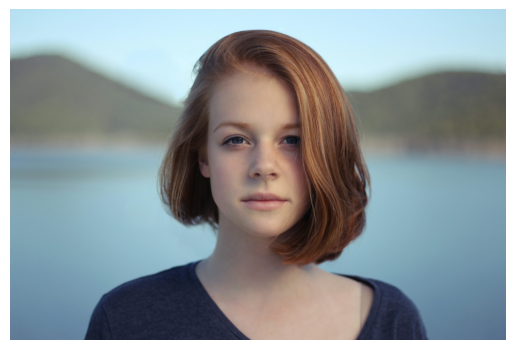

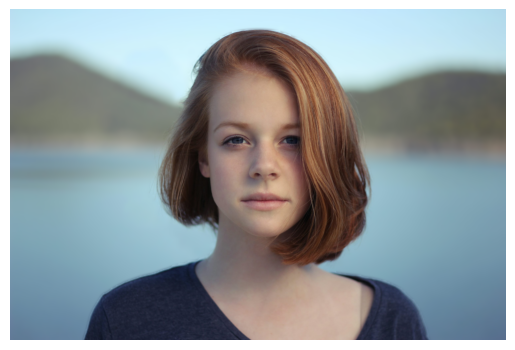

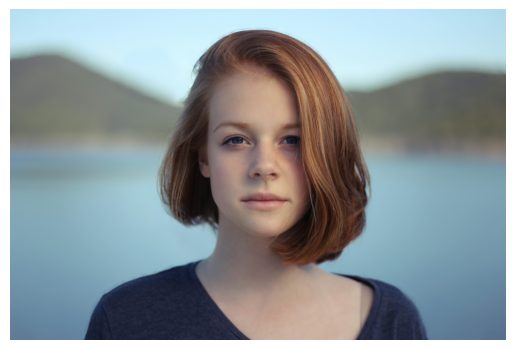

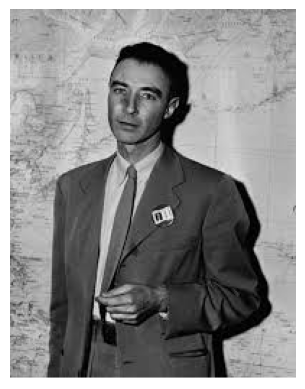

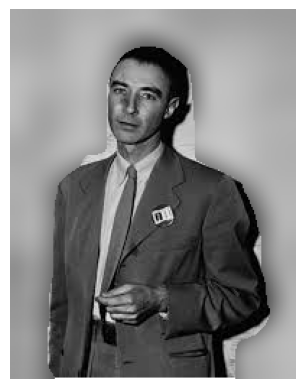

In [65]:
# Blur backgrounds
def blur_background(bg):
    return cv2.GaussianBlur(bg, (35, 35), 10)

def compose_image(img, obj_mask, bg_mask):
    obj = img * np.expand_dims(obj_mask, axis=-1)
    bg = blur_background(img) * np.expand_dims(bg_mask, axis=-1)
    return obj + bg

show_image(plain)
plain_wavelet_restored = compose_image(plain, plain_wavelet, bg_plain_wavelet)
show_image(plain_wavelet_restored)

woman_wavelet_restored = compose_image(woman, woman_wavelet, bg_woman_wavelet)
woman_wavelet_horizon_restored = compose_image(woman, woman_wavelet_horizon, bg_woman_wavelet_horizon)
show_image(woman)
show_image(woman_wavelet_restored)
show_image(woman_wavelet_horizon_restored)

oppenheimer_wavelet_restored = compose_image(oppenheimer, oppenheimer_wavelet, bg_oppenheimer_wavelet)
show_image(oppenheimer)
show_image(oppenheimer_wavelet_restored)
